In [2]:
import sys
import shutil
sys.path.append('../dependencies/')
import pyemu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pathlib as pl
import os, platform

/Users/mnfienen/Documents/GIT/WDNR_WU/HiCap_Analysis_Tool/examples/../dependencies/pyemu/pst/pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


In [4]:
pst_name='./MASTER_SEN/global_sens.pst'

In [5]:
pst = pyemu.Pst(pst_name)

error parsing metadata from 'obsnme', continuing


In [6]:
morris_sum_file = pst_name.replace('.pst','.msn')

In [7]:
morris_df = pd.read_csv(morris_sum_file, index_col=0)

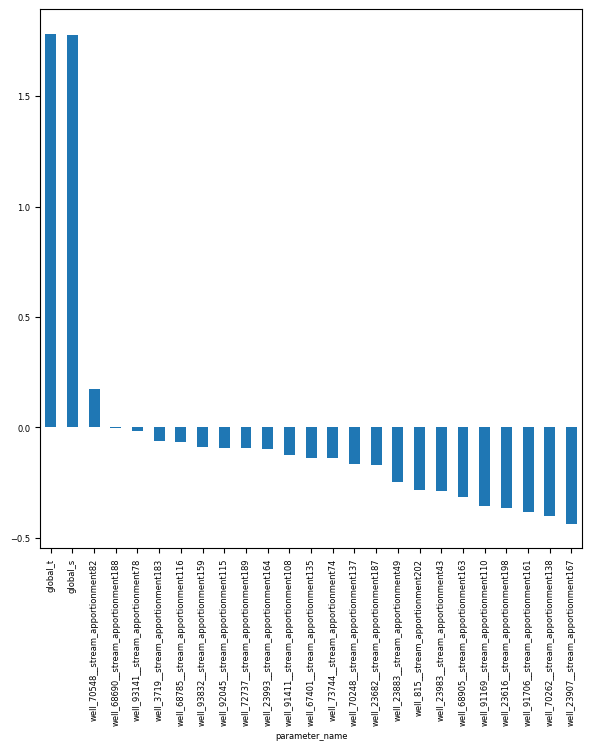

In [11]:
ax = morris_df.sort_values(by='sen_mean_abs',ascending=False).iloc[:25].sen_mean_abs.apply(np.log10).plot.bar(figsize=(7,7))


,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd,splitthresh,splitreldiff,splitaction,extra
pargpnme,,,,,,,,,,,
pargp,pargp,relative,0.01,0.0,switch,2.0,parabolic,1.0000000000e-05,5.0000000000e-01,smaller,NaN
